# Method 1 - Best Ideas Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Calculate Market Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

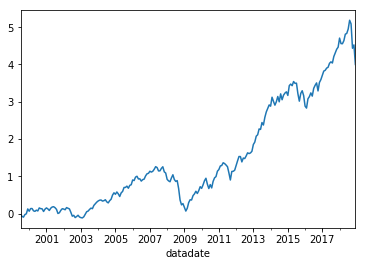

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.126602
2000-12-31   -0.004971
2001-12-31    0.010516
2002-12-31   -0.195557
2003-12-31    0.435826
2004-12-31    0.191383
2005-12-31    0.139018
2006-12-31    0.172568
2007-12-31    0.003177
2008-12-31   -0.391796
2009-12-31    0.357023
2010-12-31    0.240757
2011-12-31    0.012094
2012-12-31    0.234472
2013-12-31    0.465365
2014-12-31    0.089535
2015-12-31   -0.023574
2016-12-31    0.102917
2017-12-31    0.189230
2018-12-31   -0.084851
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     675.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.74e-125
Time:                        19:08:45   Log-Likelihood:                 686.64
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.443      0.015       0.000       0.004
mktrf          0.9818      0.024     40.481      0.000       0.934       1.030
me             0.3201      0.028     11.345      0.000       0.264       0.376
ia             0.0939      0.043      2.190      0.030       0.009       0.178
roe            0.1229      0.037      3.349      0.001       0.051       0.195
==============================================================================
Omnibus:                       15.591   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.751
Skew:                           0.014   Prob(JB):                     1.16e-10
Kurtosis:                       5.166   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     704.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.22e-127
Time:                        19:08:45   Log-Likelihood:                 686.64
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.899      0.004       0.001       0.004
mktrf          0.9818      0.030     32.398      0.000       0.922       1.041
me             0.3201      0.050      6.419      0.000       0.222       0.418
ia             0.0939      0.090      1.046      0.296      -0.082       0.270
roe            0.1229      0.038      3.249      0.001       0.049       0.197
==============================================================================
Omnibus:                       15.591   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.751
Skew:                           0.014   Prob(JB):                     1.16e-10
Kurtosis:                       5.166   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     971.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.48e-142
Time:                        19:08:45   Log-Likelihood:                 686.64
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.777      0.005       0.001       0.004
mktrf          0.9818      0.028     34.846      0.000       0.927       1.037
me             0.3201      0.045      7.097      0.000       0.232       0.408
ia             0.0939      0.098      0.956      0.339      -0.099       0.286
roe            0.1229      0.039      3.178      0.001       0.047       0.199
==============================================================================
Omnibus:                       15.591   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.751
Skew:                           0.014   Prob(JB):                     1.16e-10
Kurtosis:                       5.166   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     515.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.86e-122
Time:                        19:08:45   Log-Likelihood:                 681.90
No. Observations:                 234   AIC:                            -1352.
Df Residuals:                     228   BIC:                            -1331.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.254      0.025       0.000       0.004
mktrf          0.9725      0.025     39.131      0.000       0.924       1.022
smb            0.3675      0.033     11.206      0.000       0.303       0.432
hml            0.0644      0.039      1.666      0.097      -0.012       0.141
rmw            0.1428      0.044      3.267      0.001       0.057       0.229
cma           -0.0069      0.056     -0.124      0.901      -0.116       0.103
==============================================================================
Omnibus:                       11.590   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.799
Skew:                           0.001   Prob(JB):                     1.52e-06
Kurtosis:                       4.658   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     579.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.96e-127
Time:                        19:08:45   Log-Likelihood:                 681.90
No. Observations:                 234   AIC:                            -1352.
Df Residuals:                     228   BIC:                            -1331.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.418      0.016       0.000       0.004
mktrf          0.9725      0.029     33.074      0.000       0.915       1.030
smb            0.3675      0.038      9.716      0.000       0.293       0.442
hml            0.0644      0.066      0.970      0.332      -0.066       0.195
rmw            0.1428      0.047      3.011      0.003       0.050       0.236
cma           -0.0069      0.102     -0.068      0.946      -0.206       0.192
==============================================================================
Omnibus:                       11.590   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.799
Skew:                           0.001   Prob(JB):                     1.52e-06
Kurtosis:                       4.658   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     611.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.18e-130
Time:                        19:08:45   Log-Likelihood:                 681.90
No. Observations:                 234   AIC:                            -1352.
Df Residuals:                     228   BIC:                            -1331.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.198      0.028       0.000       0.004
mktrf          0.9725      0.030     32.623      0.000       0.914       1.031
smb            0.3675      0.034     10.758      0.000       0.301       0.434
hml            0.0644      0.072      0.899      0.368      -0.076       0.205
rmw            0.1428      0.043      3.318      0.001       0.058       0.227
cma           -0.0069      0.102     -0.068      0.946      -0.207       0.193
==============================================================================
Omnibus:                       11.590   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.799
Skew:                           0.001   Prob(JB):                     1.52e-06
Kurtosis:                       4.658   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     629.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.97e-122
Time:                        19:08:45   Log-Likelihood:                 679.03
No. Observations:                 234   AIC:                            -1348.
Df Residuals:                     229   BIC:                            -1331.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.673      0.008       0.001       0.004
mktrf          0.9830      0.023     42.613      0.000       0.938       1.028
smb            0.2543      0.029      8.833      0.000       0.198       0.311
hml            0.1875      0.029      6.554      0.000       0.131       0.244
umd            0.0853      0.019      4.544      0.000       0.048       0.122
==============================================================================
Omnibus:                       13.630   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               28.178
Skew:                          -0.235   Prob(JB):                     7.61e-07
Kurtosis:                       4.634   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     728.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.20e-129
Time:                        19:08:45   Log-Likelihood:                 679.03
No. Observations:                 234   AIC:                            -1348.
Df Residuals:                     229   BIC:                            -1331.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.642      0.008       0.001       0.004
mktrf          0.9830      0.033     29.519      0.000       0.918       1.048
smb            0.2543      0.047      5.424      0.000       0.162       0.346
hml            0.1875      0.066      2.850      0.004       0.059       0.316
umd            0.0853      0.030      2.814      0.005       0.026       0.145
==============================================================================
Omnibus:                       13.630   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               28.178
Skew:                          -0.235   Prob(JB):                     7.61e-07
Kurtosis:                       4.634   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     889.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.48e-138
Time:                        19:08:45   Log-Likelihood:                 679.03
No. Observations:                 234   AIC:                            -1348.
Df Residuals:                     229   BIC:                            -1331.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.606      0.009       0.001       0.004
mktrf          0.9830      0.030     32.645      0.000       0.924       1.042
smb            0.2543      0.047      5.433      0.000       0.163       0.346
hml            0.1875      0.072      2.611      0.009       0.047       0.328
umd            0.0853      0.023      3.654      0.000       0.040       0.131
==============================================================================
Omnibus:                       13.630   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               28.178
Skew:                          -0.235   Prob(JB):                     7.61e-07
Kurtosis:                       4.634   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     294.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.05e-59
Time:                        19:08:45   Log-Likelihood:                 334.95
No. Observations:                 120   AIC:                            -659.9
Df Residuals:                     115   BIC:                            -646.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.474      0.143      -0.001       0.005
mktrf          1.0143      0.039     25.954      0.000       0.937       1.092
me             0.3074      0.039      7.963      0.000       0.231       0.384
ia             0.1346      0.060      2.226      0.028       0.015       0.254
roe            0.1858      0.054      3.473      0.001       0.080       0.292
==============================================================================
Omnibus:                        7.740   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               13.104
Skew:                           0.197   Prob(JB):                      0.00143
Kurtosis:                       4.570   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     321.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.89e-61
Time:                        19:08:45   Log-Likelihood:                 334.95
No. Observations:                 120   AIC:                            -659.9
Df Residuals:                     115   BIC:                            -646.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.990      0.047    3.26e-05       0.004
mktrf          1.0143      0.048     21.192      0.000       0.920       1.108
me             0.3074      0.049      6.299      0.000       0.212       0.403
ia             0.1346      0.099      1.364      0.173      -0.059       0.328
roe            0.1858      0.056      3.319      0.001       0.076       0.296
==============================================================================
Omnibus:                        7.740   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               13.104
Skew:                           0.197   Prob(JB):                      0.00143
Kurtosis:                       4.570   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     502.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.89e-72
Time:                        19:08:45   Log-Likelihood:                 334.95
No. Observations:                 120   AIC:                            -659.9
Df Residuals:                     115   BIC:                            -646.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.915      0.056   -5.04e-05       0.004
mktrf          1.0143      0.045     22.440      0.000       0.926       1.103
me             0.3074      0.044      7.056      0.000       0.222       0.393
ia             0.1346      0.102      1.324      0.186      -0.065       0.334
roe            0.1858      0.056      3.299      0.001       0.075       0.296
==============================================================================
Omnibus:                        7.740   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               13.104
Skew:                           0.197   Prob(JB):                      0.00143
Kurtosis:                       4.570   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     211.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.11e-56
Time:                        19:08:46   Log-Likelihood:                 329.58
No. Observations:                 120   AIC:                            -647.2
Df Residuals:                     114   BIC:                            -630.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.424      0.157      -0.001       0.005
mktrf          1.0103      0.043     23.341      0.000       0.925       1.096
smb            0.3789      0.049      7.728      0.000       0.282       0.476
hml            0.0440      0.060      0.732      0.466      -0.075       0.163
rmw            0.2117      0.071      2.988      0.003       0.071       0.352
cma            0.0535      0.078      0.689      0.492      -0.100       0.207
==============================================================================
Omnibus:                        3.728   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                4.236
Skew:                           0.092   Prob(JB):                        0.120
Kurtosis:                       3.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     223.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.89e-57
Time:                        19:08:46   Log-Likelihood:                 329.58
No. Observations:                 120   AIC:                            -647.2
Df Residuals:                     114   BIC:                            -630.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.582      0.114      -0.001       0.005
mktrf          1.0103      0.057     17.648      0.000       0.898       1.123
smb            0.3789      0.050      7.540      0.000       0.280       0.477
hml            0.0440      0.108      0.407      0.684      -0.168       0.256
rmw            0.2117      0.091      2.329      0.020       0.034       0.390
cma            0.0535      0.125      0.429      0.668      -0.191       0.298
==============================================================================
Omnibus:                        3.728   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                4.236
Skew:                           0.092   Prob(JB):                        0.120
Kurtosis:                       3.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     250.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.67e-60
Time:                        19:08:46   Log-Likelihood:                 329.58
No. Observations:                 120   AIC:                            -647.2
Df Residuals:                     114   BIC:                            -630.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.511      0.131      -0.001       0.005
mktrf          1.0103      0.060     16.911      0.000       0.893       1.127
smb            0.3789      0.045      8.336      0.000       0.290       0.468
hml            0.0440      0.122      0.360      0.719      -0.195       0.283
rmw            0.2117      0.096      2.200      0.028       0.023       0.400
cma            0.0535      0.127      0.421      0.674      -0.196       0.303
==============================================================================
Omnibus:                        3.728   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                4.236
Skew:                           0.092   Prob(JB):                        0.120
Kurtosis:                       3.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     255.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.25e-56
Time:                        19:08:46   Log-Likelihood:                 327.25
No. Observations:                 120   AIC:                            -644.5
Df Residuals:                     115   BIC:                            -630.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      2.311      0.023       0.001       0.007
mktrf          0.9930      0.037     27.047      0.000       0.920       1.066
smb            0.2298      0.042      5.498      0.000       0.147       0.313
hml            0.2306      0.042      5.507      0.000       0.148       0.313
umd            0.0880      0.026      3.410      0.001       0.037       0.139
==============================================================================
Omnibus:                        2.890   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.443
Skew:                          -0.212   Prob(JB):                        0.295
Kurtosis:                       3.555   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     310.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-60
Time:                        19:08:46   Log-Likelihood:                 327.25
No. Observations:                 120   AIC:                            -644.5
Df Residuals:                     115   BIC:                            -630.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.043      0.002       0.001       0.006
mktrf          0.9930      0.052     19.205      0.000       0.892       1.094
smb            0.2298      0.051      4.524      0.000       0.130       0.329
hml            0.2306      0.075      3.058      0.002       0.083       0.378
umd            0.0880      0.038      2.341      0.019       0.014       0.162
==============================================================================
Omnibus:                        2.890   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.443
Skew:                          -0.212   Prob(JB):                        0.295
Kurtosis:                       3.555   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     409.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.48e-67
Time:                        19:08:46   Log-Likelihood:                 327.25
No. Observations:                 120   AIC:                            -644.5
Df Residuals:                     115   BIC:                            -630.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.333      0.001       0.001       0.006
mktrf          0.9930      0.045     21.968      0.000       0.904       1.082
smb            0.2298      0.048      4.769      0.000       0.135       0.324
hml            0.2306      0.078      2.964      0.003       0.078       0.383
umd            0.0880      0.028      3.096      0.002       0.032       0.144
==============================================================================
Omnibus:                        2.890   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.443
Skew:                          -0.212   Prob(JB):                        0.295
Kurtosis:                       3.555   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     595.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.77e-73
Time:                        19:08:46   Log-Likelihood:                 379.85
No. Observations:                 114   AIC:                            -749.7
Df Residuals:                     109   BIC:                            -736.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.075      0.003       0.001       0.004
mktrf          0.9506      0.026     36.576      0.000       0.899       1.002
me             0.3585      0.040      8.936      0.000       0.279       0.438
ia            -0.1087      0.056     -1.954      0.053      -0.219       0.002
roe           -0.1100      0.049     -2.249      0.027      -0.207      -0.013
==============================================================================
Omnibus:                        2.478   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.991
Skew:                          -0.186   Prob(JB):                        0.370
Kurtosis:                       3.529   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     978.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.10e-84
Time:                        19:08:46   Log-Likelihood:                 379.85
No. Observations:                 114   AIC:                            -749.7
Df Residuals:                     109   BIC:                            -736.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.728      0.006       0.001       0.005
mktrf          0.9506      0.017     56.723      0.000       0.918       0.983
me             0.3585      0.029     12.363      0.000       0.302       0.415
ia            -0.1087      0.077     -1.416      0.157      -0.259       0.042
roe           -0.1100      0.054     -2.034      0.042      -0.216      -0.004
==============================================================================
Omnibus:                        2.478   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.991
Skew:                          -0.186   Prob(JB):                        0.370
Kurtosis:                       3.529   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1402.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-92
Time:                        19:08:46   Log-Likelihood:                 379.85
No. Observations:                 114   AIC:                            -749.7
Df Residuals:                     109   BIC:                            -736.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.325      0.020       0.000       0.005
mktrf          0.9506      0.013     71.196      0.000       0.924       0.977
me             0.3585      0.029     12.519      0.000       0.302       0.415
ia            -0.1087      0.084     -1.290      0.197      -0.274       0.056
roe           -0.1100      0.052     -2.117      0.034      -0.212      -0.008
==============================================================================
Omnibus:                        2.478   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.991
Skew:                          -0.186   Prob(JB):                        0.370
Kurtosis:                       3.529   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     596.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.74e-77
Time:                        19:08:46   Log-Likelihood:                 392.66
No. Observations:                 114   AIC:                            -773.3
Df Residuals:                     108   BIC:                            -756.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.371      0.020       0.000       0.003
mktrf          0.9592      0.022     43.104      0.000       0.915       1.003
smb            0.3357      0.036      9.293      0.000       0.264       0.407
hml           -0.0543      0.046     -1.179      0.241      -0.146       0.037
rmw           -0.2227      0.056     -3.947      0.000      -0.334      -0.111
cma           -0.0959      0.072     -1.339      0.183      -0.238       0.046
==============================================================================
Omnibus:                        0.131   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.003
Skew:                           0.002   Prob(JB):                        0.999
Kurtosis:                       3.025   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1225.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.33e-93
Time:                        19:08:46   Log-Likelihood:                 392.66
No. Observations:                 114   AIC:                            -773.3
Df Residuals:                     108   BIC:                            -756.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.139      0.032       0.000       0.004
mktrf          0.9592      0.015     65.066      0.000       0.930       0.988
smb            0.3357      0.029     11.505      0.000       0.279       0.393
hml           -0.0543      0.051     -1.074      0.283      -0.153       0.045
rmw           -0.2227      0.055     -4.032      0.000      -0.331      -0.114
cma           -0.0959      0.079     -1.219      0.223      -0.250       0.058
==============================================================================
Omnibus:                        0.131   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.003
Skew:                           0.002   Prob(JB):                        0.999
Kurtosis:                       3.025   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1216.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.54e-93
Time:                        19:08:46   Log-Likelihood:                 392.66
No. Observations:                 114   AIC:                            -773.3
Df Residuals:                     108   BIC:                            -756.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.753      0.080      -0.000       0.004
mktrf          0.9592      0.015     64.010      0.000       0.930       0.989
smb            0.3357      0.026     13.020      0.000       0.285       0.386
hml           -0.0543      0.044     -1.221      0.222      -0.142       0.033
rmw           -0.2227      0.057     -3.880      0.000      -0.335      -0.110
cma           -0.0959      0.072     -1.333      0.183      -0.237       0.045
==============================================================================
Omnibus:                        0.131   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.003
Skew:                           0.002   Prob(JB):                        0.999
Kurtosis:                       3.025   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     663.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.62e-75
Time:                        19:08:46   Log-Likelihood:                 385.80
No. Observations:                 114   AIC:                            -761.6
Df Residuals:                     109   BIC:                            -747.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.252      0.213      -0.001       0.003
mktrf          0.9871      0.023     42.229      0.000       0.941       1.033
smb            0.3826      0.036     10.496      0.000       0.310       0.455
hml           -0.0066      0.038     -0.176      0.861      -0.081       0.068
umd            0.0552      0.028      1.950      0.054      -0.001       0.111
==============================================================================
Omnibus:                        3.328   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                2.722
Skew:                          -0.337   Prob(JB):                        0.256
Kurtosis:                       3.346   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2073.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.92e-102
Time:                        19:08:46   Log-Likelihood:                 385.80
No. Observations:                 114   AIC:                            -761.6
Df Residuals:                     109   BIC:                            -747.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.167      0.243      -0.001       0.003
mktrf          0.9871      0.015     68.010      0.000       0.959       1.016
smb            0.3826      0.029     13.171      0.000       0.326       0.440
hml           -0.0066      0.045     -0.146      0.884      -0.096       0.082
umd            0.0552      0.019      2.903      0.004       0.018       0.093
==============================================================================
Omnibus:                        3.328   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                2.722
Skew:                          -0.337   Prob(JB):                        0.256
Kurtosis:                       3.346   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2749.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.00e-108
Time:                        19:08:46   Log-Likelihood:                 385.80
No. Observations:                 114   AIC:                            -761.6
Df Residuals:                     109   BIC:                            -747.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.994      0.320      -0.001       0.003
mktrf          0.9871      0.015     67.594      0.000       0.958       1.016
smb            0.3826      0.027     13.955      0.000       0.329       0.436
hml           -0.0066      0.041     -0.160      0.873      -0.088       0.075
umd            0.0552      0.018      3.039      0.002       0.020       0.091
==============================================================================
Omnibus:                        3.328   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                2.722
Skew:                          -0.337   Prob(JB):                        0.256
Kurtosis:                       3.346   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""